In [1]:
import pandas as pd
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases

import time 
import multiprocessing 


In [2]:

df2 = pd.read_parquet('../../Files/Submissions/score/done/Pro_vac.parquet')


In [3]:
instances = df2['cleanText'].tolist()

In [6]:
phrases = Phrases(instances, min_count=5, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=50, no_above=0.3)
print(dictionary, flush=True)

Dictionary(22539 unique tokens: ['[NUM]', 'accurately', 'corona_virus', 'measurement', 'people']...)


In [8]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [9]:
coherence_values = []



for num_topics in range(5, 16):
    model = LdaMulticore(corpus=model_corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics, random_state=42)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances, 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=instances, 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

5 -3.375405227361118 0.4153457153661229
6 -3.557001525561646 0.41346106285948586
7 -3.0959994813775658 0.3961461869558084
8 -3.384619125836279 0.3996037453542074
9 -3.22616287274671 0.4000832199131755
10 -3.3605962775818163 0.39689732512004006
11 -3.2770363099558293 0.4006143400862436
12 -3.2726643241651385 0.39283314192757685
13 -3.0371063220887615 0.3968270439536893
14 -3.592253318221444 0.4172341724504211
15 -3.4664035959691537 0.4041951285974675


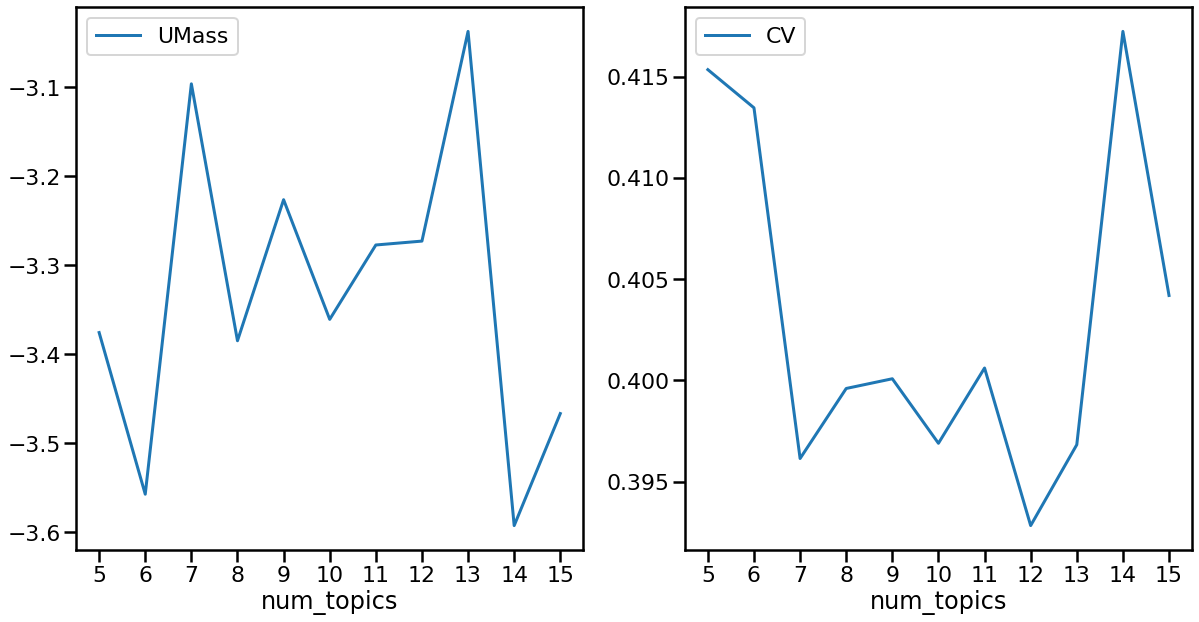

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context('poster') # use large font


scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
# scores['UMass'] = -scores['UMass']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));